# Auto-tuning Kalman Filter on a 1D Simulated Trajectory

In [1]:
import numpy as np
np.random.seed(10015)
from matplotlib import pyplot as plt
%matplotlib inline

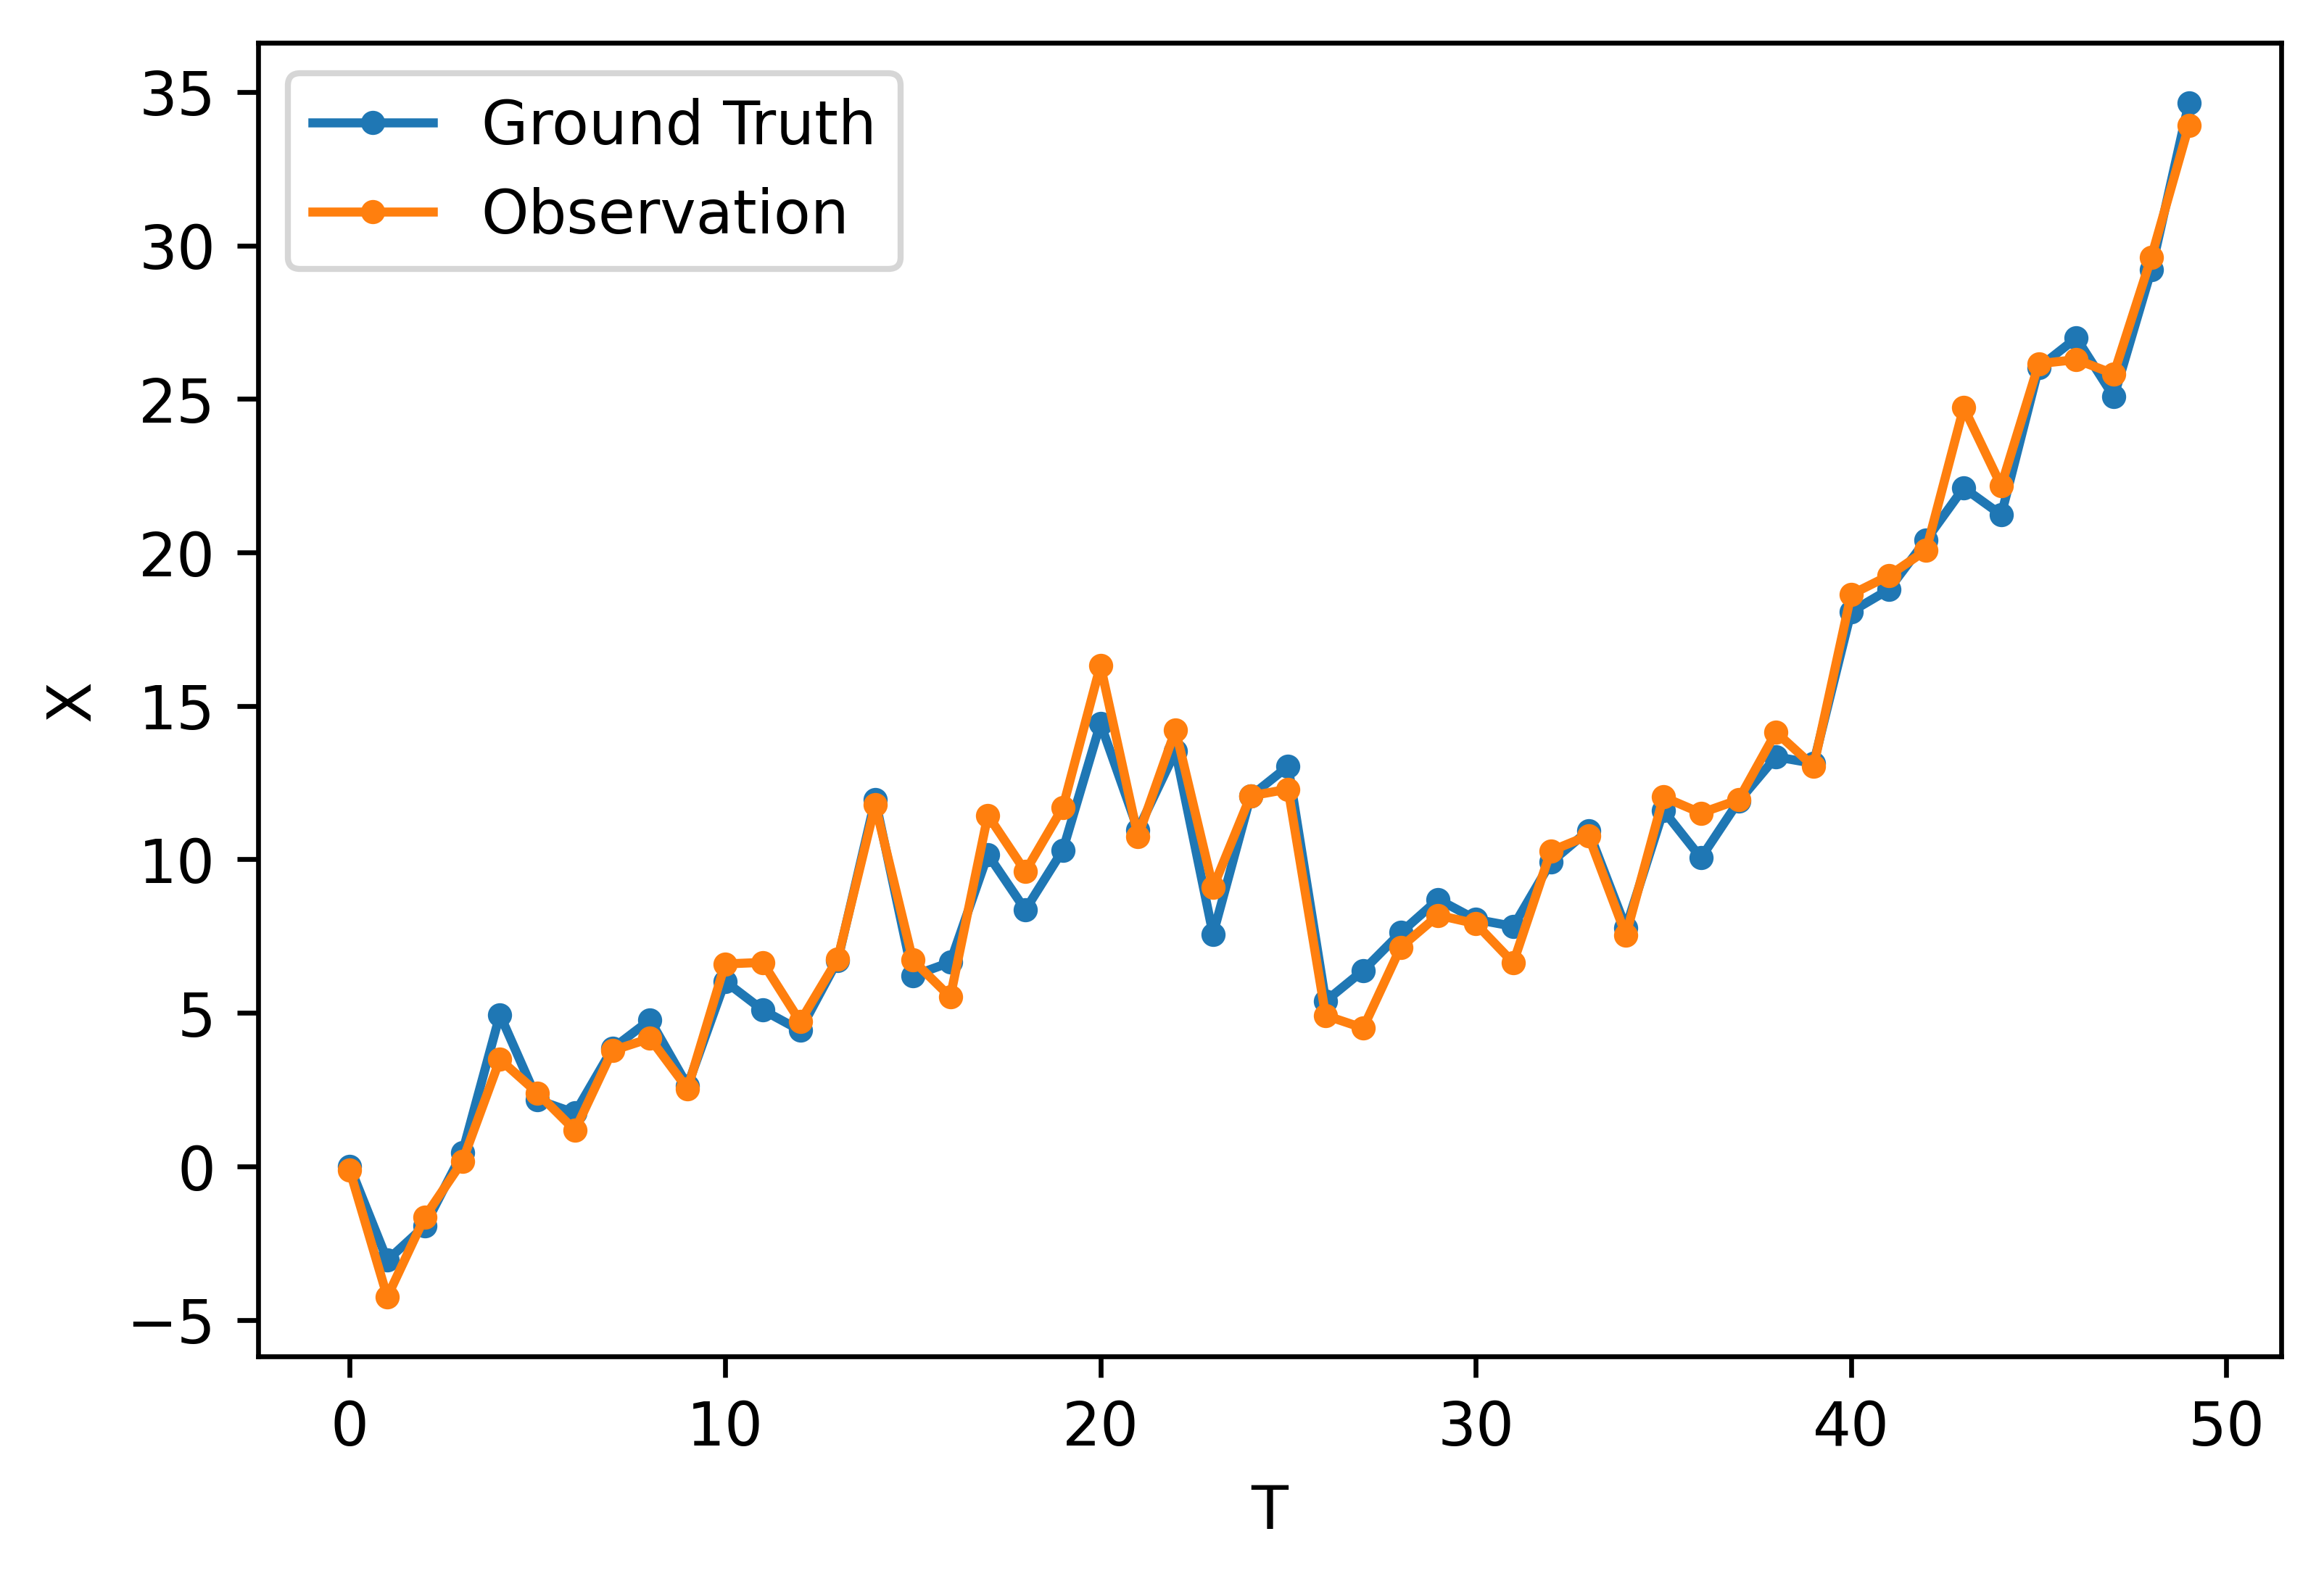

In [2]:
# Simulate a 1D trajectory.
from utils import TrajSimulator1D

traj_simulator = TrajSimulator1D(
    dt=0.01, duration=0.5, initial_state=np.array([[0.0]]), q_var=1000.0, r_var=1.0
)

# gt: ground truth, obs: observation
gt_traj, obs_traj = traj_simulator.simulate()

fig = plt.figure(dpi=600)
plt.plot(gt_traj, marker='.', linestyle='-', label='Ground Truth')
plt.plot(obs_traj, marker='.', linestyle='-', label='Observation')
plt.legend()
plt.xlabel('T');
plt.ylabel('X');

In [3]:
# Build the Kalman filter tuning model.
from utils import KalmanFilterTuningModel

# Specify intial P.
P = 1000.0*np.eye(1)
tuning_model = KalmanFilterTuningModel(dim_x=1, dim_z=1, 
                                      F=traj_simulator.F, 
                                      H=traj_simulator.H, 
                                      initial_state=traj_simulator.initial_state, 
                                      P=P, 
                                      observation=obs_traj)

In [4]:
# Build the optimizer.
from hyperopt import hp, fmin, tpe

# Set Object function.
def J(args):
    q_var, r_var = args
    Q = q_var * np.array([traj_simulator.dt])
    R = np.eye(1) * r_var
    nis_loss = tuning_model.get_filter_nis_loss(Q, R)
    return nis_loss

# Set parameter space for searching.
param_space = [
    hp.uniform('q_var', 0, 1000),
    hp.uniform('r_var', 0, 1)
]

optimal_param = fmin(J, param_space, algo=tpe.suggest, max_evals=1000)

100%|████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.74trial/s, best loss: 6.321911127197408e-05]


In [5]:
print('Optimal parameters:\n q_var: {}\n r_var: {}'.format(optimal_param['q_var'], optimal_param['r_var']))

Optimal parameters:
 q_var: 299.51570797857323
 r_var: 0.8593605188075075


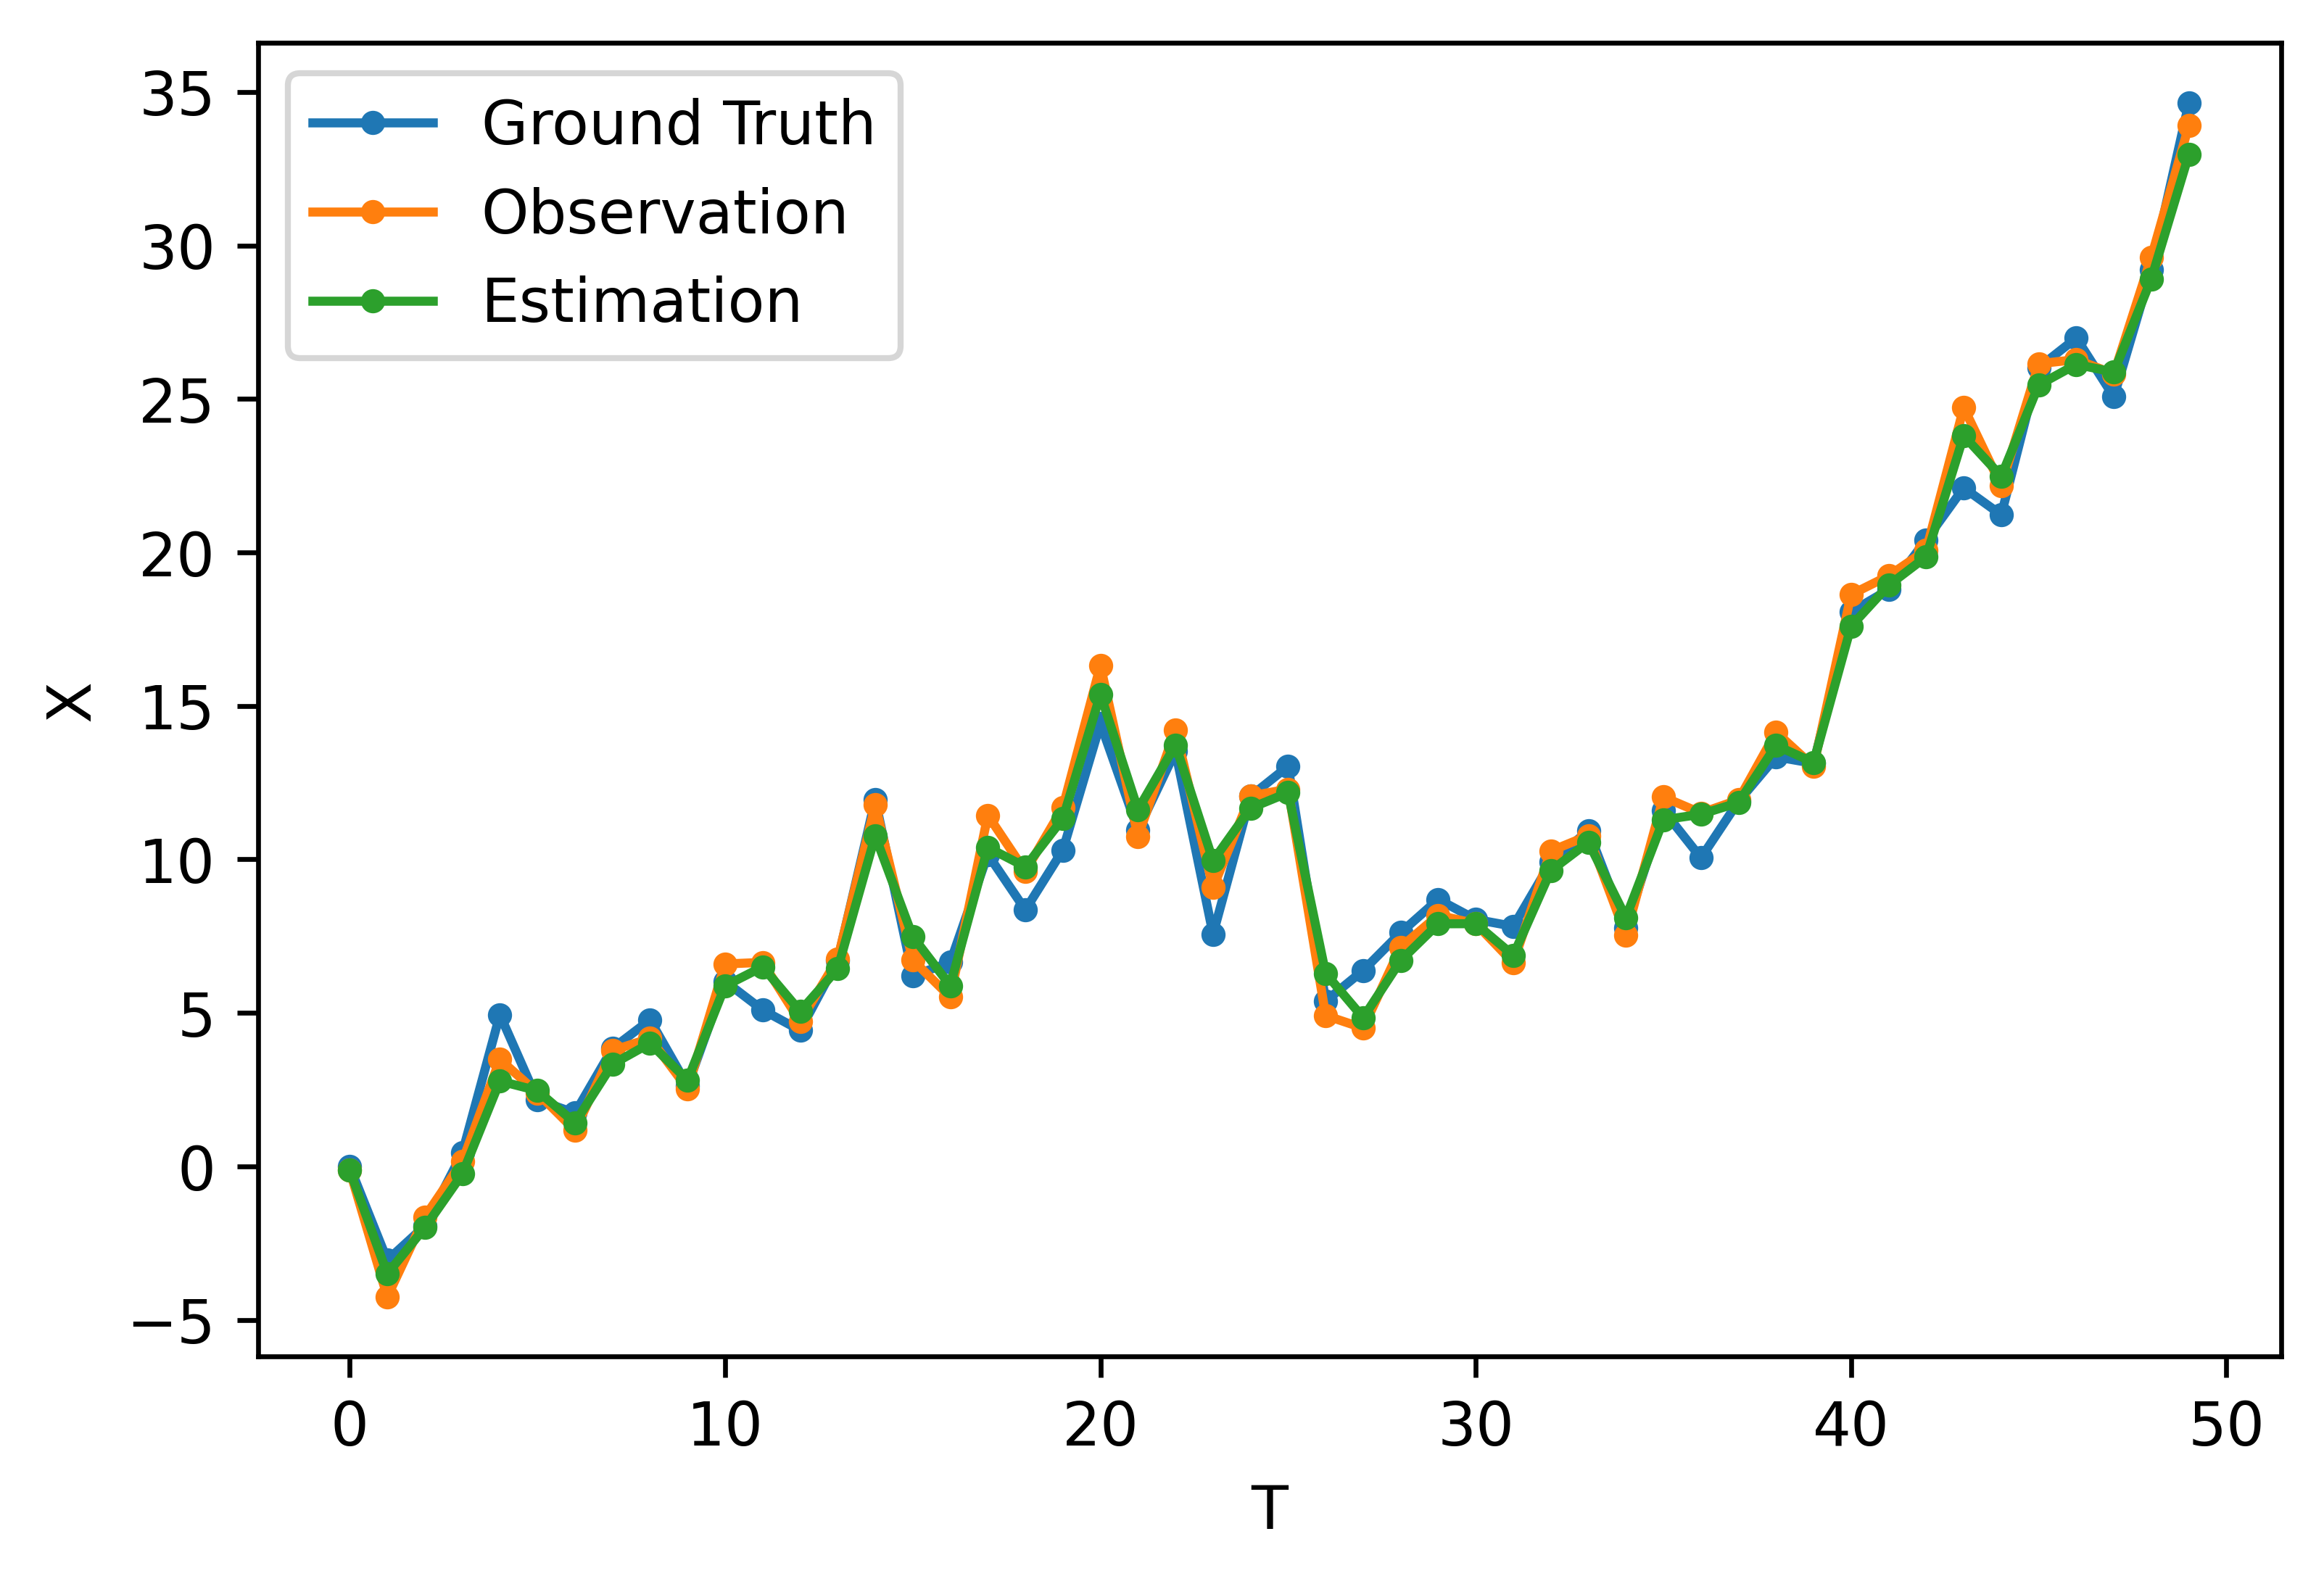

In [6]:
# Build a Kalman filter using the optimal Q and R.
from filterpy.kalman import KalmanFilter

kalman_filter = KalmanFilter(dim_x=1, dim_z=1)
kalman_filter.F = traj_simulator.F
kalman_filter.H = traj_simulator.H
kalman_filter.x = traj_simulator.initial_state
kalman_filter.P = P

best_q_var = optimal_param['q_var']
best_r_var = optimal_param['r_var']
kalman_filter.Q = best_q_var * np.array([[traj_simulator.dt]])
kalman_filter.R = np.array([[best_r_var]])

estimate_traj_mu, estimate_traj_cov, _, _ = kalman_filter.batch_filter(obs_traj)

# Draw the estimated trajectory with optimal filter parameters.
fig = plt.figure(dpi=600)
plt.plot(gt_traj, marker='.', linestyle='-', label='Ground Truth')
plt.plot(obs_traj, marker='.', linestyle='-', label='Observation')
plt.plot(estimate_traj_mu.reshape(-1), marker='.', linestyle='-', label='Estimation')
plt.legend()
plt.xlabel('T');
plt.ylabel('X');